In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly #used plotly graphing library for maps
import plotly.express as px
import plotly.graph_objects as go 

In [2]:
final_df = pd.read_csv('final_df.csv')

**Import Random Forest Regressor for feature importances**

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

**Feature importances to use in Random Forest death rate model**

In [4]:
X = final_df._get_numeric_data().drop(columns=['death_rate', 'deaths', 'gini_index'])
y = final_df['death_rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
        
        #scale data
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)
        
        #fit random forest regressor
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
        #get feature importances
feature_names = [f'feature {i}' for i in range(X.shape[1])]

result = permutation_importance(rf, X_train, y_train, 
                                n_repeats=10, random_state=42, 
                                n_jobs=-1)
        #create dataframe
forest_importances = pd.Series(result.importances_mean, index=feature_names)
feature_df = pd.DataFrame(columns = ['index'])
feature_df['forest_importances'] = forest_importances
feature_df.drop(columns=['index'], inplace=True)
features = list(X.T.index)
feature_df['feature'] = features
        #sort by top 20

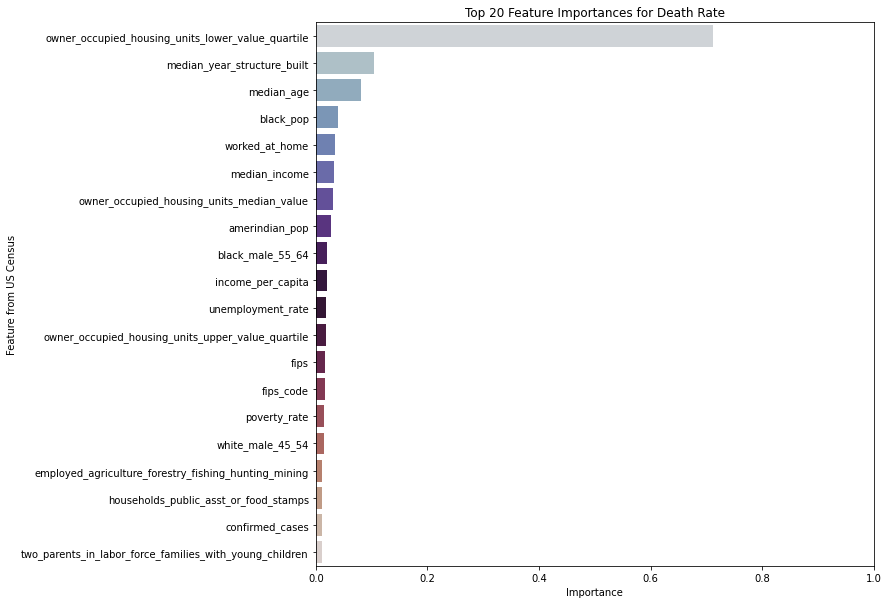

In [5]:
top_20 = feature_df.sort_values(by='forest_importances', ascending=False).head(20)
        #bar plot for sorted importances
plt.figure(figsize=(10, 10))
sns.barplot(x=top_20['forest_importances'], y=top_20['feature'],
           palette='twilight')

plt.xticks(ticks=[0, .2, .4, .6, .8, 1.0])

plt.xlabel('Importance')
plt.ylabel('Feature from US Census')
plt.title('Top 20 Feature Importances for Death Rate');

In [6]:
income_cols = [col for col in final_df.columns if 'income' in col or 'poverty' in col or 'group_quarters' in col]
income_cols#group quarters leaked data

['median_income',
 'income_per_capita',
 'income_less_10000',
 'income_10000_14999',
 'income_15000_19999',
 'income_20000_24999',
 'income_25000_29999',
 'income_30000_34999',
 'income_35000_39999',
 'income_40000_44999',
 'income_45000_49999',
 'income_50000_59999',
 'income_60000_74999',
 'income_75000_99999',
 'income_100000_124999',
 'income_125000_149999',
 'income_150000_199999',
 'income_200000_or_more',
 'pop_determined_poverty_status',
 'poverty',
 'percent_income_spent_on_rent',
 'group_quarters',
 'poverty_rate']

**Visualization for `poverty_rate` feature importances**

In [7]:
X = final_df._get_numeric_data().drop(columns=income_cols)
y = final_df['poverty_rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
        
        #scale data
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)
        
        #fit random forest regressor
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
        #get feature importances
feature_names = [f'feature {i}' for i in range(X.shape[1])]

result = permutation_importance(rf, X_train, y_train, 
                                n_repeats=10, random_state=42, 
                                n_jobs=-1)
        #create dataframe
pov_forest_importances = pd.Series(result.importances_mean, index=feature_names)
pov_feature_df = pd.DataFrame(columns = ['index'])
pov_feature_df['forest_importances'] = forest_importances
pov_feature_df.drop(columns=['index'], inplace=True)
pov_features = list(X.T.index)
pov_feature_df['feature'] = features
        #sort by top 20

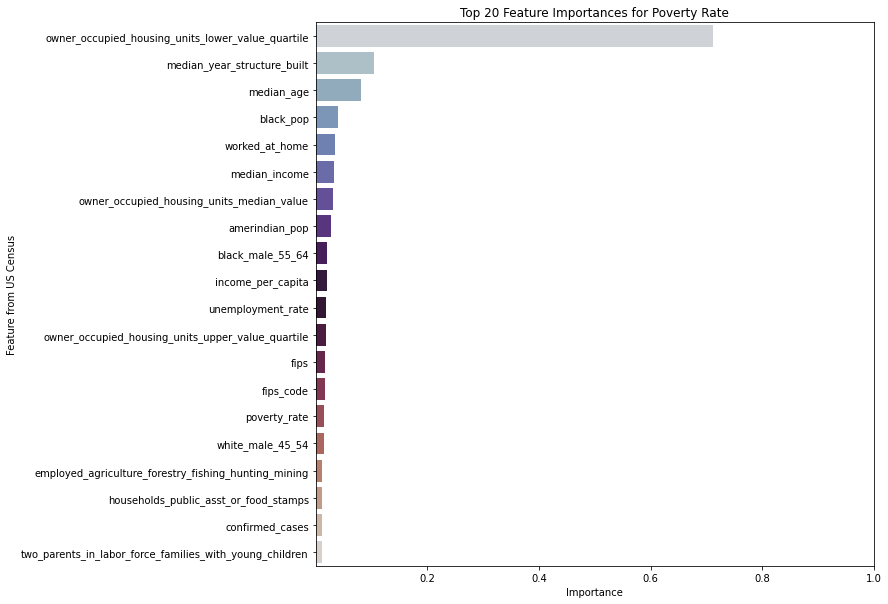

In [8]:
pov_top_20 = feature_df.sort_values(by='forest_importances', ascending=False).head(20)
        #bar plot for sorted importances
plt.figure(figsize=(10, 10))
sns.barplot(x=pov_top_20['forest_importances'], y=pov_top_20['feature'],
           palette='twilight')

plt.xticks(ticks=[.2, .4, .6, .8, 1])

plt.xlabel('Importance')
plt.ylabel('Feature from US Census')
plt.title('Top 20 Feature Importances for Poverty Rate');

**Set up Random Forest Regressor for death rate (only target used in this notebook**

In [9]:
features = [col for col in top_20['feature']]

In [10]:
X = final_df[features]
y = final_df['death_rate']

In [11]:
#baseline
preds_base = np.ones(X_test.shape[0]) * np.mean(y_test)
r2_score(y_test, preds_base)

0.0

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33)

In [13]:
pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=33))
])

In [14]:
def print_gs(gs, X_train, X_test, y_train, y_test):
    results = gs.cv_results_
    cv_mean = gs.cv_results_['mean_test_score'][gs.best_index_]
    cv_range = 2 * gs.cv_results_['std_test_score'][gs.best_index_]
    print('Best Score: ', gs.best_score_)
    print(f'Cross Val Score {cv_mean} +/- {cv_range}')
    print('Test Score: ', gs.score(X_test, y_test))
    print('Best Params: ', gs.best_params_)

In [15]:
params_rf = {

}
gs_rf = GridSearchCV(pipe_rf, param_grid=params_rf, n_jobs=-1)
gs_rf.fit(X_train, y_train)
print_gs(gs_rf, X_train, X_test, y_train, y_test)

Best Score:  0.36030836413930434
Cross Val Score 0.36030836413930434 +/- 0.0684718488109917
Test Score:  0.3624652029664446
Best Params:  {}


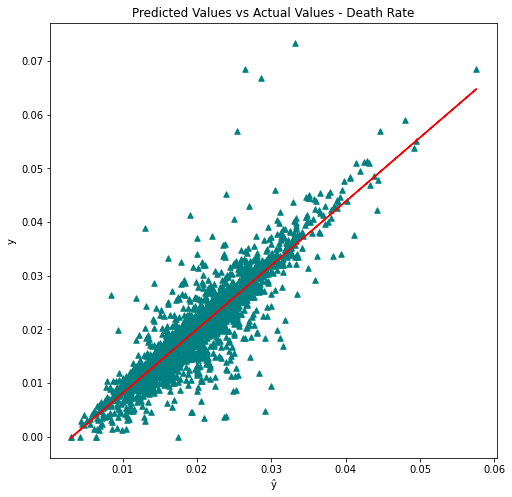

score:  0.3624652029664446


In [16]:
graph_pred  =  gs_rf.predict(X)
score       =  gs_rf.score(X_test, y_test)

plt.figure(figsize=(8,8))
plt.scatter(graph_pred, y,
           s = 30,
           color = 'teal',
           marker = '^')

plt.title('Predicted Values vs Actual Values - Death Rate')
plt.xlabel('ŷ')
plt.ylabel('y')

m, b = np.polyfit(graph_pred, y, 1)

plt.plot(graph_pred, m*graph_pred+b, color='red')

plt.show()

print("score: ", score)

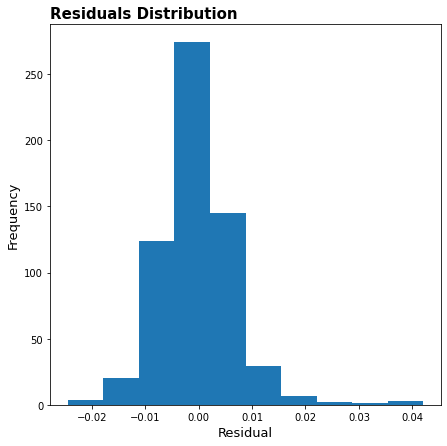

In [17]:
preds = gs_rf.predict(X_test)
residuals = y_test - preds
fig, ax = plt.subplots(figsize=(7, 7))
plt.hist(residuals)
plt.title('Residuals Distribution',
          loc='left', fontweight='bold', fontsize=15)
plt.xlabel('Residual', size=13)
plt.ylabel('Frequency', size=13);

**Interpretation:** We can infer than these features are good determiners of death rate because the residuals are close to normally distributed. 